# A4 - COVID-19 Infection Rates in County Middlesex, MA

The notebook creates a visualization of the number of confirmed COVID-19 cases, along with trends of the rate of infection and the periods of mask mandates in the county of Middlesex, Massachusetts (county assigned by the teaching staff), with the goal of answering the following question:

    How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?

## Data Processing

The data used in the analysis comes from several different sources:

- Record of confirmed cases by county [1]
- Record of mask mandates by period by county [2]
- Estimates of mask usage [3]

The data processing starts with joining the data from all the different sources and filtering for the county of interest. 

### Confirmed Cases

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reading the number of confirmed cases and selecting the county of Middlesex, Massachusetts.

In [2]:
cases_raw = pd.read_csv("cases/RAW_us_confirmed_cases.csv")
cases_raw = cases_raw.rename(columns = {'Province_State': 'State', 'Admin2': 'County'})

In [3]:
cases = cases_raw.loc[(cases_raw['State'] == 'Massachusetts') & (cases_raw['County'] == 'Middlesex')]

In [4]:
cases = cases.drop(['State', 'County', 'UID', 'iso2', 'iso3', 'Combined_Key', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_'], axis=1)

In [5]:
cases

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21
1274,0,0,0,0,0,0,0,0,0,0,...,157854,157854,158495,158740,159020,159020,159612,159612,159612,160294


Next, pivot the table to create a time series.

In [6]:
cases = cases.stack().reset_index().rename(columns = {'level_1': 'Date', 0: 'Cases'}).drop('level_0', axis=1)

And update the format of the date column.

In [7]:
cases['Date'] = pd.to_datetime(cases['Date'], infer_datetime_format=True)

### Mask Mandate

Loading the mask mandate records and selecting the county of interest.

In [8]:
masks_raw = pd.read_csv("masks_mandate/US_State_and_Territorial_Public_Mask_Mandates_by_County_by_Day.csv")

In [9]:
masks_mandate = masks_raw.loc[(masks_raw['State_Tribe_Territory'] == 'MA') & (masks_raw['County_Name'] == 'Middlesex County')]

In [10]:
masks_mandate = pd.DataFrame(masks_mandate, columns=['date', 'order_code'])

Adjusting date format.

In [11]:
masks_mandate['date'] = pd.to_datetime(masks_mandate['date'], infer_datetime_format=True)
masks_mandate = masks_mandate.reset_index()

## Visualization

In [12]:
import matplotlib.patches as mpatches

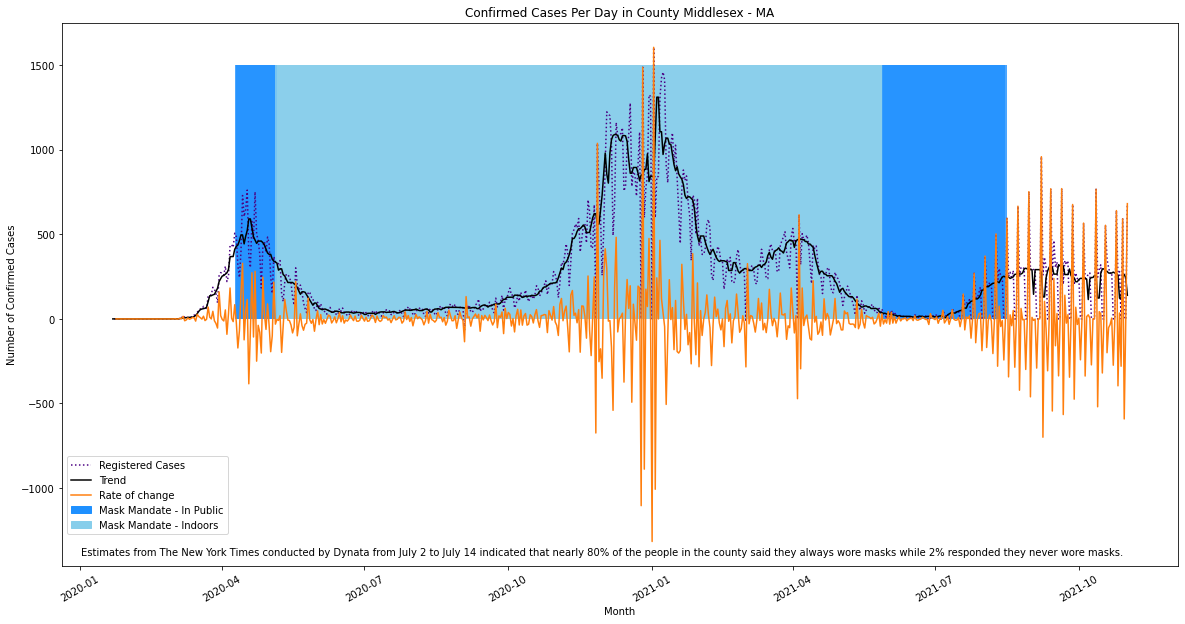

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.xlabel("Month")
plt.ylabel("Number of Confirmed Cases")
plt.title("Confirmed Cases Per Day in County Middlesex - MA")

l1, = plt.plot(cases.Date, cases.Cases.diff(), color='indigo', linestyle='dotted', label="Registered Cases")
l2, = plt.plot(cases.Date, cases.Cases.diff().rolling(window=10, min_periods=3, center=True).median(), color='black', linestyle='solid', label="Trend")

rate_of_change = cases.Cases.diff().diff() / cases.index.to_series().diff()
l3, = plt.plot(cases.Date, rate_of_change, color='tab:orange', linestyle='-', label="Rate of change")

colors = np.where(masks_mandate['order_code'] > 1, 'dodgerblue', 'skyblue')
plt.bar(masks_mandate.date, 1500, color=colors, alpha=0.8, width=2)

legend_items = [
    l1,
    l2,
    l3,
    mpatches.Patch(color='dodgerblue', label='Mask Mandate - In Public'),
    mpatches.Patch(color='skyblue', label='Mask Mandate - Indoors'),
]

plt.legend(loc='lower left', handles=legend_items, bbox_to_anchor=(0, 0.05))
plt.xticks(rotation=30)

fig.text(.5, 0.14, "Estimates from The New York Times conducted by Dynata from July 2 to July 14 indicated that nearly 80% of the people in the county said they always wore masks while 2% responded they never wore masks.", ha='center')

plt.show()

The purple line shows the number of cases registered per day in the county. The trend, shown in black, is calculated as the median of a 10-day moving window to smoothen any weekly seasonality present in the data as demonstrated in Image 1. The orange line represents the rate of change (or acceleration) in the trend of daily infection (number of cases divided by population at risk). Finally, the blue areas indicate the period of mask mandates by the local government - dark blue indicating mask mandate in public areas and light blue indicating mandates for masks in retail and food establishments. The note at the bottom warns of the fact that, despite the mask mandates, not all local population adheres to the guidelines [3].

## Reflection

Analysing the impact of mask mandates on the daily trend of COVID-19 cases is difficult because there is no division between control and experiment groups within the same local community, and the effects observed in the visualization are influenced by a number of factors that are not controlled for, or for which we don’t have additional data to take into consideration. For example, it is possible to assume a delay in the effect of mask usage, because it will take time for the benefits to be detected - people already infected may develop symptoms over a few days before getting tested and the numbers would reflect this lag. Another variable would be the vaccine availability and local vaccination rate because regardless of the mask usage, the infection rates will tend to decrease if the population is vaccinated. Vaccination rates have also affected people’s propensity to wear a mask, even though vaccinated people are known to still be vulnerable to infection and possibly spreading of the virus. Also, although it is possible to assume some correlations between anti-maskers and anti-vaxxers, no data was used in that regard.

Nevertheless, the period around the initial mask mandate, April 2020 to March 2020, shows a decline in the rate of infection which may be attributed to the mask mandate. However, further analysis is necessary, including using additional data to evaluate other aspects such as local culture and events (local gatherings and festivals in the area), difference in mask usage over time and, most importantly, it would be good to consider other types of analysis such as comparing similar communities with different mask mandate policies over the same period of time, or a more rigorous A/B test.

## Data Sources

[1] Record of COVID-19 confirmed cases and deaths by state, dataset from Johns Hopkins University and distributed through Kaggle under CC BY 4.0 license.

[2] "U.S. State and Territorial Public Mask Mandates From April 10, 2020 through August 15, 2021 by County by Day". Data Provided by Mara Howard-Williams, Public Health Law Program, Center for State, Tribal, Local, and Territorial Support, Centers for Disease Control and Prevention and available for download directly from the CDC at https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i

[3] Mask Usage: Estimates are from The New York Times, based on roughly 250,000 interviews conducted by Dynata from July 2 to July 14 and available on a [GitHub repository](https://github.com/nytimes/covid-19-data/tree/master/mask-use) under a specific [copyright notice and attribution request](https://github.com/nytimes/covid-19-data/blob/master/LICENSE).